<a href="https://colab.research.google.com/github/ABUALHUSSEIN/Fraud-Detection-in-Financial-Transactions-Using-Machine-Learning/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fraud Detection in Financial Transactions Using Machine Learning**

In [ ]:
from IPython.display import display, HTML

display(HTML("""
<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/ABUALHUSSEIN/Fraud-Detection-in-Financial-Transactions-Using-Machine-Learning/refs/heads/main/Fraud_Detection.jpg" width="1000">
</div>
"""))

# Understand the Dataset
The PaySim1 dataset simulates mobile money transactions and includes labeled data for fraudulent and legitimate transactions. First, let's explore its structure and contents.

We want to detect fraudulent financial transactions to reduce financial loss and protect customers.

# Step 1: Load and Inspect the Data

In [ ]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

In [ ]:
# Install gdown to download the file
!pip install gdown

# Download kaggle.json using the file ID
import gdown

# File ID from your Google Drive link
file_id = '1pxw_J2_BTT5JeBLyLkvVhs3oFzWbN2By'
gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', 'kaggle.json', quiet=False)

# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Downloading...
From: https://drive.google.com/uc?export=download&id=1pxw_J2_BTT5JeBLyLkvVhs3oFzWbN2By
To: /content/kaggle.json
100%|██████████| 73.0/73.0 [00:00<00:00, 149kB/s]


In [ ]:
!kaggle datasets download -d ealaxi/paysim1
!unzip paysim1.zip


Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
Archive:  paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  


In [ ]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
column_names = df.columns.tolist()
print(column_names)


['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


The PaySim dataset simulates mobile money transactions and includes the following key features:

- step: Time step of the transaction in hours.
- type: Type of transaction (e.g., PAYMENT, TRANSFER, CASH_OUT).
- amount: Transaction amount.
- nameOrig and nameDest: Sender and receiver identifiers.
- oldbalanceOrg and newbalanceOrig: Sender's balance before and after the transaction.
- oldbalanceDest and newbalanceDest: Receiver's balance before and after the transaction.
- isFraud: Indicates if the transaction is fraudulent.
- isFlaggedFraud: Flags illegal attempts, such as transfers over a certain threshold.


# Step 2: Exploratory Data Analysis (EDA) & Preprocessing:

In [ ]:
# Check the data types and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


type, nameOrig and nameDest are of object datatype

nameOrig and nameDest are identifier-like columns that do not contribute to the predictive modeling; therefore, we will drop them in the subsequent step.

In [ ]:
print(df.shape)

(6362620, 11)


The dataset has ~6.3 million rows and 11 columns.


In [ ]:
# Check for missing values
df.isnull().sum()




,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
# Check for duplicate rows
duplicates = df.duplicated()

# Show how many duplicates there are
print(f"Number of duplicate rows: {duplicates.sum()}")




Number of duplicate rows: 0


In [ ]:
# Get basic statistics
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


###  Check Inconsistencies in type:
To identify the number of unique transaction types


In [ ]:
#Check Inconsistencies in type:
# Step 1: Check unique transaction types
print(df['type'].value_counts())

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


<ipython-input-13-6ee2b127fd25>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['type'].value_counts().index, y=df['type'].value_counts().values, palette='pastel')


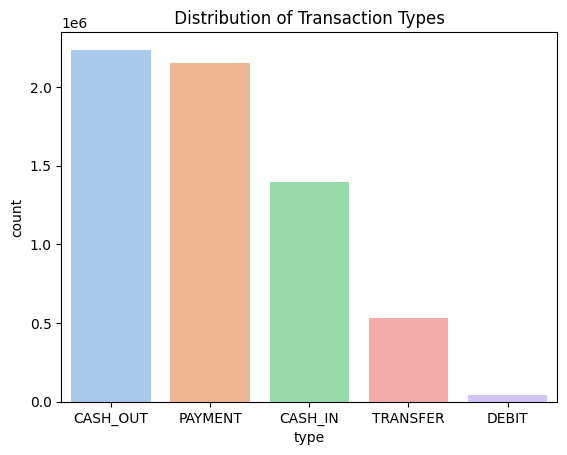

In [ ]:
sns.barplot(x=df['type'].value_counts().index, y=df['type'].value_counts().values, palette='pastel')
plt.xlabel('type')
plt.ylabel('count')
plt.title(' Distribution of Transaction Types ')
plt.show()


Since the categorical column contains only five unique values.
The most frequent transaction types are CASH-OUT and PAYMENT.




In [ ]:
df['isFlaggedFraud'].value_counts()

,count
isFlaggedFraud,
0,6362604
1,16


We will drop these columns:

nameOrig and nameDest: Identifier Columns

isFlaggedFraud: (Always 0 — offers no information to model or EDA _Useless Column)

It’s always 0 in this dataset ( we checked it by : df['isFlaggedFraud'].value_counts())

That means it contains no variance, and gives the model nothing to learn from

It adds zero predictive value and just wastes memory and processing

### Drop irrelevant or ID-like columns (nameOrig, nameDest, isFlaggedFraud)

In [ ]:
# Drop IDs
df = df.drop(['nameOrig', 'nameDest','isFlaggedFraud'], axis=1)

In [ ]:
# Rename columns for clarity
df.rename(columns={
    'step': 'time_step',
    'type': 'transaction_type',
    'amount': 'transaction_amount',
    'oldbalanceOrg': 'sender_old_balance',
    'newbalanceOrig': 'sender_new_balance',
    'oldbalanceDest': 'receiver_old_balance',
    'newbalanceDest': 'receiver_new_balance',
    'isFraud': 'is_fraud'
}, inplace=True)

In [ ]:
print(df.columns)  # should show 'is_fraud'


Index(['time_step', 'transaction_type', 'transaction_amount',
       'sender_old_balance', 'sender_new_balance', 'receiver_old_balance',
       'receiver_new_balance', 'is_fraud'],
      dtype='object')


In [ ]:
df.head()

,time_step,transaction_type,transaction_amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,is_fraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [ ]:
# Sample data to reduce processing (since full dataset is large)
sample_df = df.sample(n=5000, random_state=42)

In [ ]:
print("Min time_step:", df['time_step'].min())
print("Max time_step:", df['time_step'].max())
print("Unique values (optional):", df['time_step'].unique()[:10])  # preview only first 10


Min time_step: 1
Max time_step: 743
Unique values (optional): [ 1  2  3  4  5  6  7  8  9 10]






### Pairplots

A pairplot is a graph that shows relationships between multiple variables in a dataset
The pairplot gives you a visual sense of separation between fraudulent and non-fraudulent transactions.

Due to memory limitations in Google Colab resulting in a session crash, we will mitigate the issue by sampling a subset of the dataset for exploratory analysis.

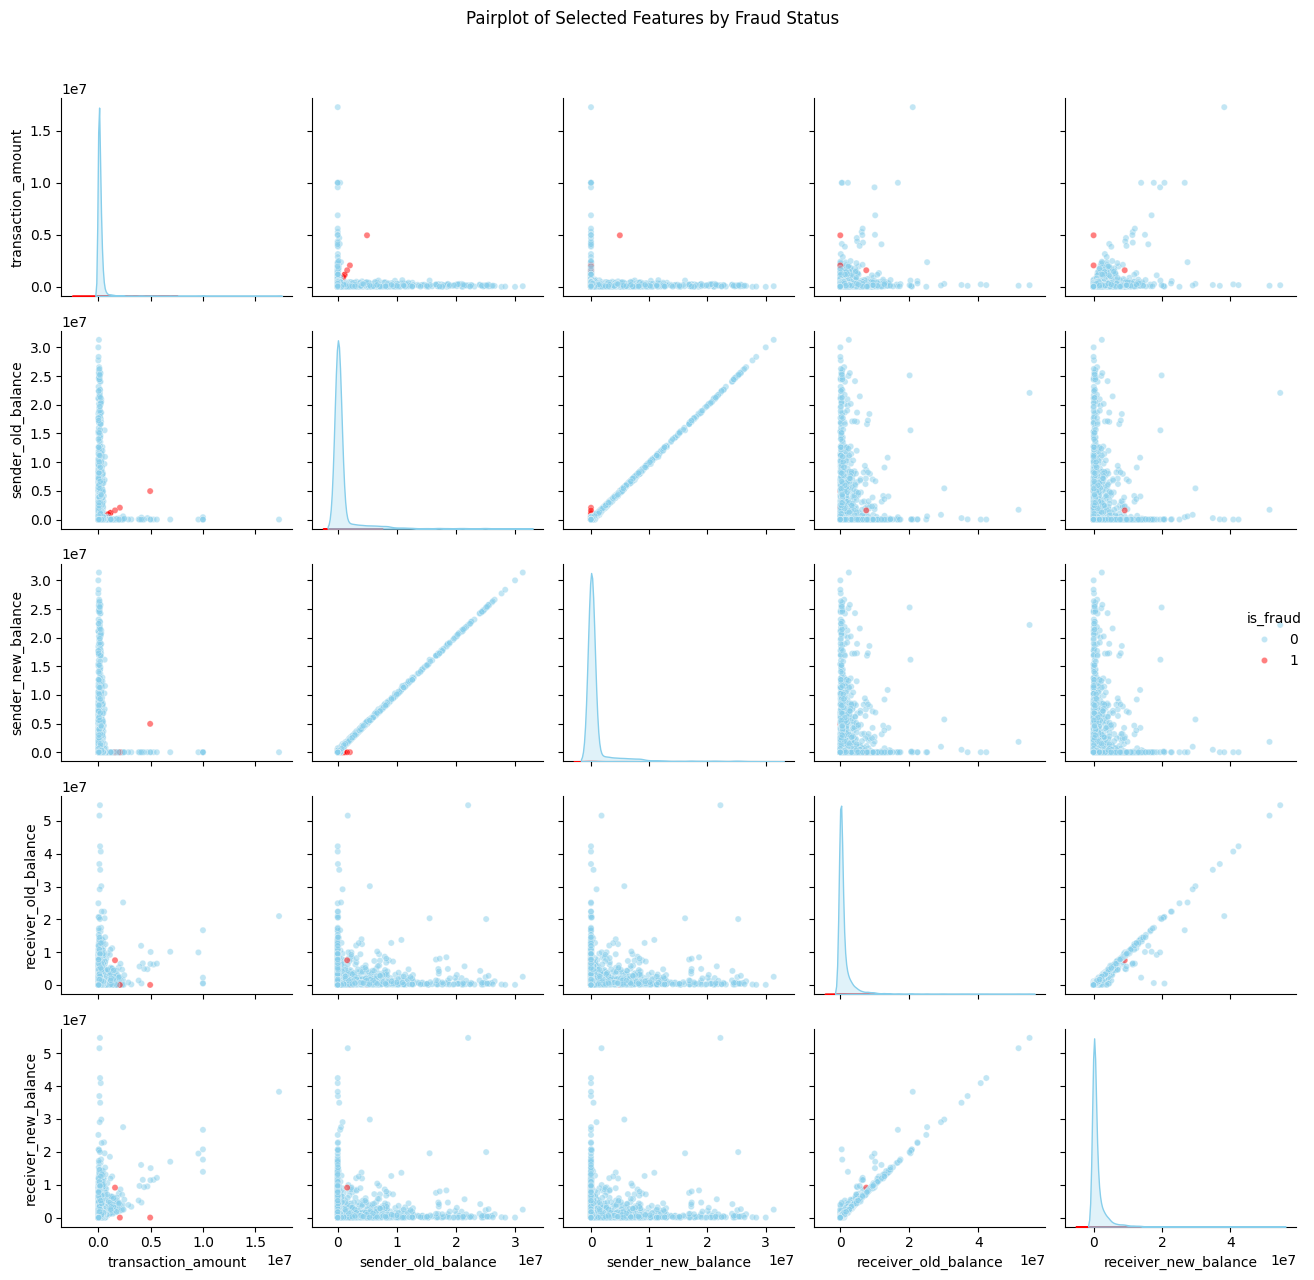

In [ ]:
# Plot pairplot of selected numerical features
sns.pairplot(sample_df,
             vars=[
                 'transaction_amount',
                 'sender_old_balance',
                 'sender_new_balance',
                 'receiver_old_balance',
                 'receiver_new_balance'
             ],
             hue='is_fraud',
             palette={0: 'skyblue', 1: 'red'},
             plot_kws={'alpha': 0.5, 's': 20},
             diag_kind='kde')

plt.suptitle("Pairplot of Selected Features by Fraud Status", y=1.02)
plt.tight_layout()
plt.show()

Comments on the Pairplot Results
1. Fraud Cases Are Rare but Distinct
As anticipated due to the class imbalance, fraudulent transactions (is_fraud = 1, shown in red) are relatively sparse across the dataset. However, these cases tend to cluster within specific regions of the feature space. This concentration suggests that fraudulent behavior follows detectable patterns, which is advantageous for the development of effective classification models.

2. High Correlation Between Sender Balances
The pairplot reveals a strong linear relationship between sender_old_balance and sender_new_balance, indicating that transaction amounts are being consistently deducted from the sender’s account. While this validates transactional integrity, the high correlation between these two variables may introduce multicollinearity. To address this, one of the variables may be removed in future steps, pending confirmation through Variance Inflation Factor (VIF) analysis.

3. Fraudulent Transactions Often Involve Zero or Low Balances
A significant proportion of fraudulent transactions occur when the sender_old_balance is zero or near zero, or when both receiver_old_balance and receiver_new_balance are zero. This observation may indicate the presence of synthetic or inactive accounts, often used in test frauds or money laundering schemes.

4. Transaction Amounts in Fraud Cases
Fraudulent transactions frequently involve large transaction amounts. This aligns with known fraud strategies, where attackers aim to extract maximum financial value in a short period before detection mechanisms are triggered.

5. Receiver Balances and Anomalous Patterns
In some fraud cases, anomalies are observed in receiver balances, such as a low initial balance followed by a sudden increase. Such abrupt changes may be indicative of suspicious activity like fund redirection, layering in money laundering, or other high-risk behaviors.



# Correlation matrix

The heatmap shows correlations with isFraud to guide feature selection.

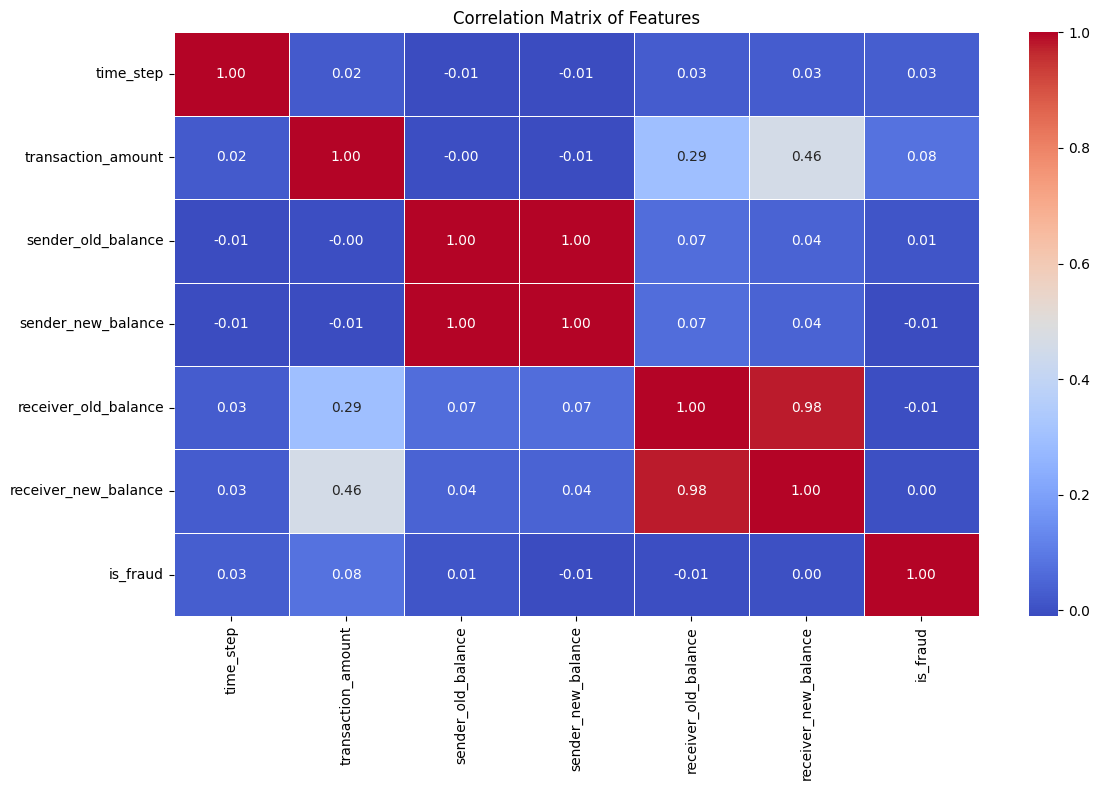

In [ ]:
# Compute the correlation matrix (numeric columns only)
corr = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()

Key Observations:

Low Correlation with isFraud:

Most features show very weak correlation with fraud (is_fraud).

The highest is amount with just ~0.08.

This implies fraud is not linearly correlated with single features — fraud detection will likely require nonlinear models or interactions between features.

Perfect Correlation Between Some Features:

oldbalanceOrg and newbalanceOrig: Correlation = 1.00

oldbalanceDest and newbalanceDest: Correlation ≈ 0.98

This indicates redundancy — you might consider dropping one of each pair (or  Replace with Engineered Features) to avoid multicollinearity in some models (e.g., Logistic Regression).



## Feature Engineering

We will replace the original features with engineered variables by creating net change (delta) features, which are designed to more effectively capture transactional behavior patterns indicative of fraud.

In [ ]:
df['sender_balance_diff'] = df['sender_old_balance'] - df['sender_new_balance']
df['receiver_balance_diff'] = df['receiver_new_balance'] - df['receiver_old_balance']

df = df.drop(['sender_old_balance', 'sender_new_balance',
              'receiver_old_balance', 'receiver_new_balance'], axis=1)


In [ ]:
df.head()

,time_step,transaction_type,transaction_amount,is_fraud,sender_balance_diff,receiver_balance_diff
0,1,PAYMENT,9839.64,0,9839.64,0.0
1,1,PAYMENT,1864.28,0,1864.28,0.0
2,1,TRANSFER,181.00,1,181.00,0.0
3,1,CASH_OUT,181.00,1,181.00,-21182.0
4,1,PAYMENT,11668.14,0,11668.14,0.0


In [ ]:
print(df.shape)

(6362620, 6)







### Check and handle class imbalance







In [ ]:
# Check imbalance
print(df['is_fraud'].value_counts())


is_fraud
0    6354407
1       8213
Name: count, dtype: int64


This confirms a highly imbalanced dataset

In [ ]:
from IPython.display import display, HTML

display(HTML('<span style="color:blue; font-weight:bold; font-size:20px;">Why plt.yscale(\'log\') Helps:</span>'))





The fraud bar is tiny compared to non-fraud.

A log scale compresses the y-axis and makes both bars more visible.

It helps people see the small class without zooming in.

<ipython-input-28-348f2d97ca4a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='is_fraud', order=[0, 1], palette='Set2')


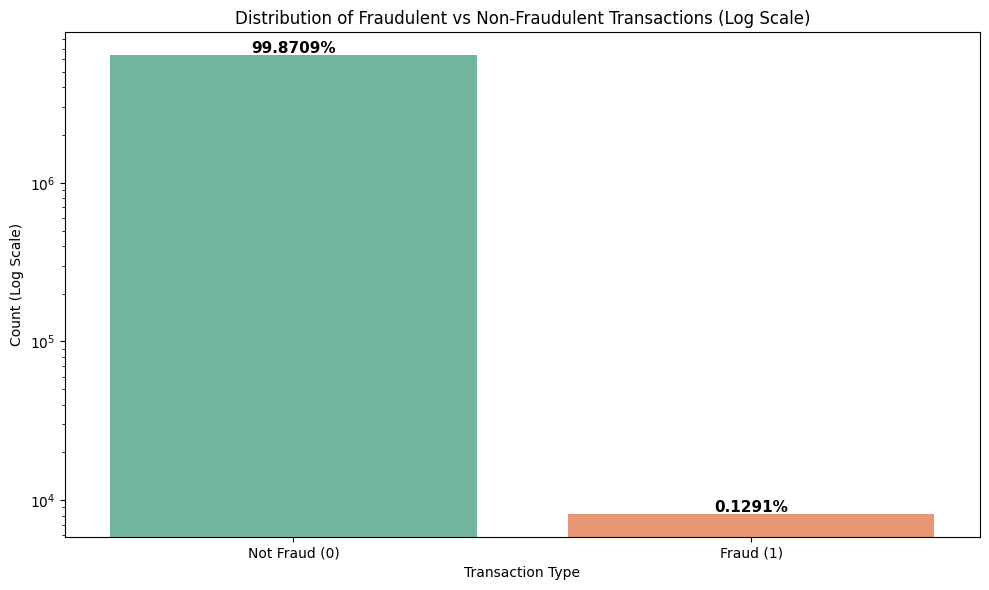

In [ ]:
# Total transactions
total = len(df)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='is_fraud', order=[0, 1], palette='Set2')

# Apply log scale to y-axis
plt.yscale('log', base=10)

# Titles and labels
plt.title("Distribution of Fraudulent vs Non-Fraudulent Transactions (Log Scale)")
plt.xlabel("Transaction Type")
plt.ylabel("Count (Log Scale)")
plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])

# Annotate: percentage above the bar
for p in ax.patches:
    count = p.get_height()
    percent = 100 * count / total
    bar_x = p.get_x() + p.get_width() / 2.

    ax.annotate(f'{percent:.4f}%',
                (bar_x, count * 1.1),  # above the bar
                ha='center', va='center',
                fontsize=11, color='black', weight='bold')

plt.tight_layout()
plt.show()

A bar plot showing how imbalanced the dataset is (fraud is typically <1%)

Now let's make a barplot to see the fraud and non fraud transactions in different transactions type

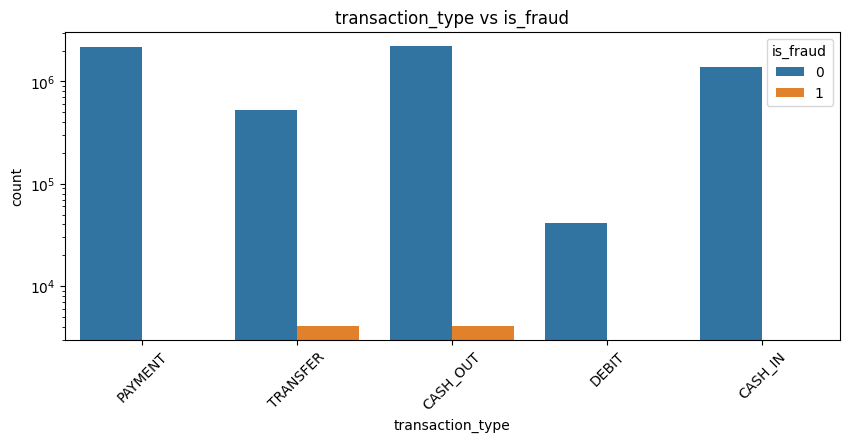

In [ ]:
# transaction_type vs is_fraud
plt.figure(figsize=(10, 4))
sns.countplot(x='transaction_type', hue='is_fraud', data=df)
plt.title('transaction_type vs is_fraud')
plt.yscale('log', base = 10)
plt.xticks(rotation=45)
plt.show()

Transaction Types: Fraud may be concentrated in specific types like TRANSFER or CASH-OUT.

In [ ]:
from IPython.display import display, HTML

display(HTML('<span style="color:blue; font-weight:bold; font-size:20px;">Goal: Reduce dataset size:</span>'))


Why we Should Sample the PaySim Data The full dataset has over 6 million rows, and:

SMOTE + GridSearch + complex models = very slow

Reduce dataset size for faster processing while preserving fraud samples (class 1).

Most fraud detection insights can be tested on a smaller, balanced subset

Sampling allows faster prototyping, then scale up later if needed

Fraudulent transactions (isFraud == 1) are extremely rare (~0.1% of 6 million rows). If you sample randomly without care, you might lose most or all fraud samples.

Best Practices to Preserve Rare Class


✅  Stratified Sampling
This ensures each class is sampled proportionally.

# Split Data into Train/Test

In [ ]:

# Define features (X) and target (y)
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

#  Train-test split : Stratified sample: preserves fraud/non-fraud ratio
X_train, X_test, y_train, y_test= train_test_split(
    X, y,
    test_size=0.3,      # use 30% of the data
    stratify=y,          # stratify by target variable
    random_state=42      # for reproducibility
)

#Show class distribution in train/test
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))


Training set class distribution:
is_fraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

Test set class distribution:
is_fraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4453834, 5) (1908786, 5) (4453834,) (1908786,)


 ## Define Common Preprocessing

In [ ]:

# --- Feature Groups ---
numeric_features = ['transaction_amount', 'sender_balance_diff', 'receiver_balance_diff', 'time_step']
categorical_features = ['transaction_type']

# --- Numeric Pipeline ---
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# --- Categorical Pipeline ---
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# --- Full Preprocessor for Logistic Regression, SVM, and Naive Bayes Pipeline ------
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])



In [ ]:
# ============================
# 7. MODEL-BY-MODEL PIPELINE
# ============================

results = {}


 # Logistic Regression

In [ ]:
# --- Logistic Regression ---
print("\n\n===== Logistic Regression =====")
# --- Pipeline ---
lr_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1] # Get predicted probabilities for class 1 (fraud)





===== Logistic Regression =====


## Tune threshold using F1 score

In [ ]:
 #Tune Decision Threshold
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []
precision_scores = []
recall_scores = []

for t in thresholds:
    y_pred_t = (y_proba_lr >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))
    precision_scores.append(precision_score(y_test, y_pred_t))
    recall_scores.append(recall_score(y_test, y_pred_t))

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold for Logistic Regression: {best_threshold:.2f}")

Best Threshold for Logistic Regression: 0.99


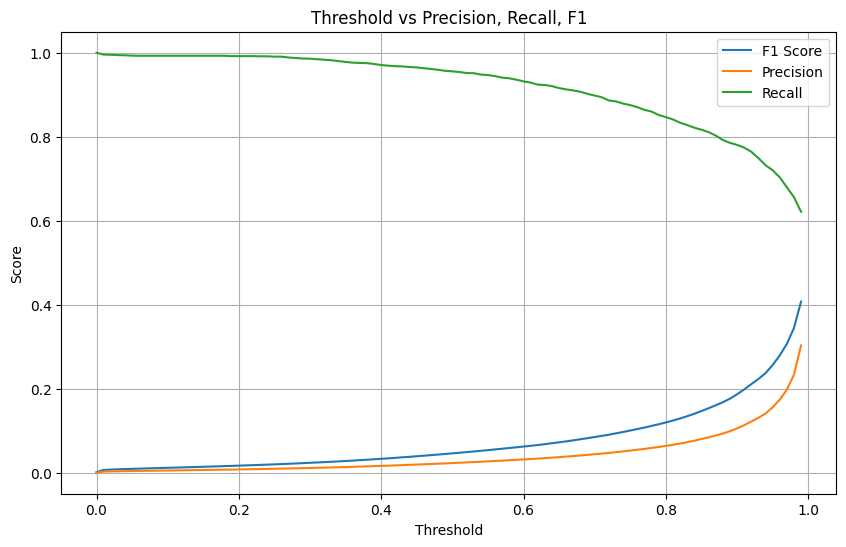

In [ ]:
#Plot threshold vs F1, precision, recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision, Recall, F1")
plt.legend()
plt.grid(True)
plt.show()


The best threshold is where the F1 Score (blue curve) is at its peak, because:

F1 Score is the harmonic mean of precision and recall.

It’s especially useful when you need to balance false positives and false negatives (common in fraud detection).

From the plot:
The F1 Score appears to peak around a threshold of ~0.98–1.0, based on the sharp rise in the blue curve.

## Evaluate model at best threshold

===== Logistic Regression Classification Report =====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.30      0.62      0.41      2464

    accuracy                           1.00   1908786
   macro avg       0.65      0.81      0.70   1908786
weighted avg       1.00      1.00      1.00   1908786



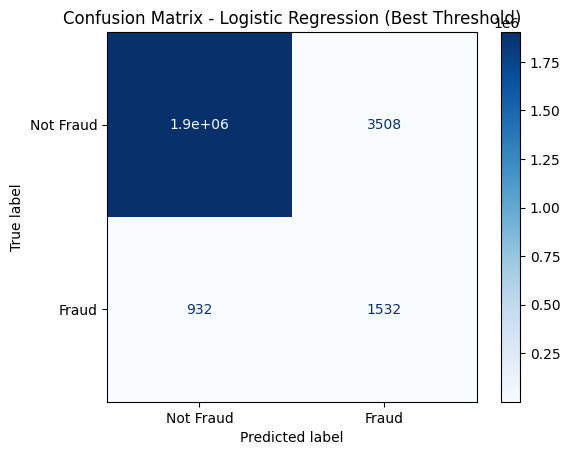

In [ ]:
#Evaluate model at best threshold

y_pred_lr = (y_proba_lr >= best_threshold).astype(int)

# Classification report
print("===== Logistic Regression Classification Report =====")
print(classification_report(y_test, y_pred_lr))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (Best Threshold)")
plt.show()




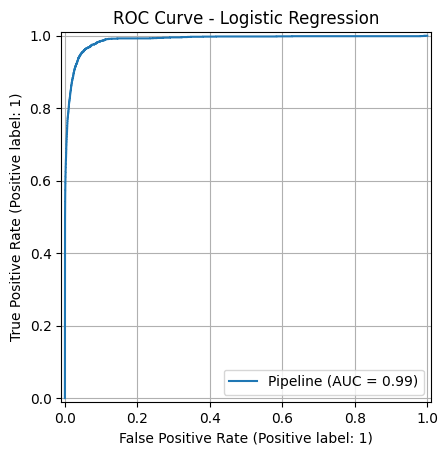

AUC Score (Logistic Regression): 0.9891


In [ ]:
# ROC Curve
RocCurveDisplay.from_estimator(lr_pipeline, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.grid(True)
plt.show()

# AUC Score
auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"AUC Score (Logistic Regression): {auc_lr:.4f}")

## Store result

In [ ]:
#Store result
results = {}
results['Logistic Regression'] = {
    'F1': max(f1_scores),
    'AUC': auc_lr,
    'Best Threshold': best_threshold
}


In [ ]:
results

{'Logistic Regression': {'F1': 0.40831556503198296,
  'AUC': np.float64(0.9891286486405583),
  'Best Threshold': np.float64(0.99)}}

# Decision Tree

 Pipelines for XGBoost, Random Forest, and Decision Tree, tailored for a fraud detection problem like PaySim1. These pipelines follow best practices and assume:

We do not need scaling or log-transforming.

In [ ]:
#----- Best Practice for  XGBoost, Random Forest, and Decision Tree Pipelines

# Preprocessing (only encode categorical)
preprocessor_tree = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

In [ ]:
# --- Decision Tree Classifier ---
print("\n\n===== Decision Tree Classifier =====")

# Create pipeline
dt_pipeline = ImbPipeline([
    ('preprocessor', preprocessor_tree),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit model
dt_pipeline.fit(X_train, y_train)

# Predict
y_pred_dt = dt_pipeline.predict(X_test)
y_proba_dt = dt_pipeline.predict_proba(X_test)[:, 1]  # Get predicted probabilities for fraud






===== Decision Tree Classifier =====


## Tune threshold using F1 score

In [ ]:
# --- Tune Decision Threshold ---

# Threshold tuning using F1 score
thresholds_dt = np.arange(0.0, 1.0, 0.01)
f1_scores_dt = []
precision_scores_dt = []
recall_scores_dt = []

for t in thresholds_dt:
    y_pred_t_dt = (y_proba_dt >= t).astype(int)
    f1_scores_dt.append(f1_score(y_test, y_pred_t_dt))
    precision_scores_dt.append(precision_score(y_test, y_pred_t_dt, zero_division=0))
    recall_scores_dt.append(recall_score(y_test, y_pred_t_dt))

best_threshold_dt = thresholds_dt[np.argmax(f1_scores_dt)]
print(f"Best Threshold for Decision Tree: {best_threshold_dt:.2f}")


Best Threshold for Decision Tree: 0.01


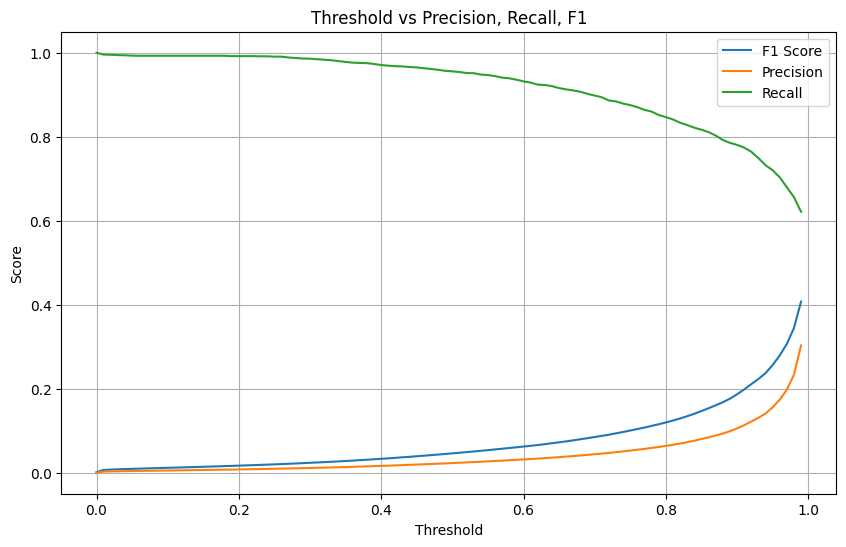

In [ ]:
#Plot threshold vs F1, precision, recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision, Recall, F1")
plt.legend()
plt.grid(True)
plt.show()


Best Threshold:
From this behavior, the best threshold is likely around 0.01, where the F1 score first reaches its peak. Since the values remain flat afterward, choosing anything from 0.01 to 1.0 gives the same performance

## Evaluate model at best threshold


Classification Report (Decision Tree at Best Threshold):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906322
           1       0.18      0.84      0.29      2464

    accuracy                           0.99   1908786
   macro avg       0.59      0.92      0.64   1908786
weighted avg       1.00      0.99      1.00   1908786



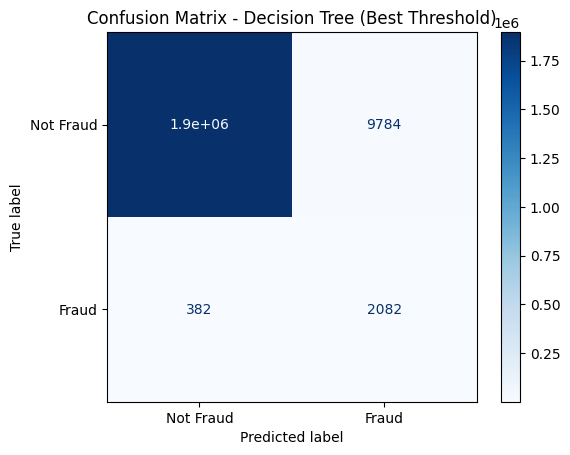

In [ ]:
#Evaluate model at best threshold
y_final_dt = (y_proba_dt >= best_threshold_dt).astype(int)

# Classification report
print("\nClassification Report (Decision Tree at Best Threshold):")
print(classification_report(y_test, y_final_dt))


# Confusion Matrix
cm = confusion_matrix(y_test, y_final_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Decision Tree (Best Threshold)")
plt.show()


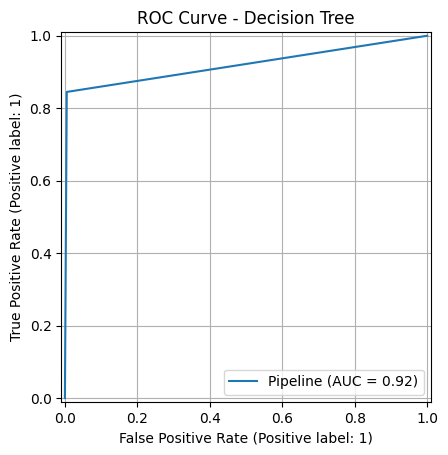

AUC Score (Decision Tree): 0.9199


In [ ]:

# ROC Curve
RocCurveDisplay.from_estimator(dt_pipeline, X_test, y_test)
plt.title("ROC Curve - Decision Tree")
plt.grid(True)
plt.show()

# AUC Score
auc_dt = roc_auc_score(y_test, y_proba_dt)
print(f"AUC Score (Decision Tree): {auc_dt:.4f}")


In [ ]:
#Store result
results = {}
results['Decision Tree'] = {
    'F1': max(f1_scores_dt),
    'AUC': auc_dt,
    'Best Threshold': best_threshold_dt
}


In [ ]:
results

{'Decision Tree': {'F1': 0.29057920446615493,
  'AUC': np.float64(0.9199175680783653),
  'Best Threshold': np.float64(0.01)}}

 # XGBoost

In [ ]:
# --- Define Model ---
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'   # ✅ Recommended to suppress eval warnings
)

In [ ]:


print("\n\n===== XGBoost =====")

# --- Pipeline ---
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor_tree),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb_model)
])






===== XGBoost =====


In [ ]:

# --- Train Model ---
xgb_pipeline.fit(X_train, y_train)

# --- Predict Probabilities for the positive class---
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

In [ ]:
# --- Threshold Tuning ---
thresholds_xgb = np.arange(0.0, 1.0, 0.01)
f1_scores_xgb = []
precision_scores_xgb = []
recall_scores_xgb = []

for t in thresholds_xgb:
    y_pred_t_xgb = (y_proba_xgb >= t).astype(int)
    f1_scores_xgb.append(f1_score(y_test, y_pred_t_xgb))
    precision_scores_xgb.append(precision_score(y_test, y_pred_t_xgb, zero_division=0))
    recall_scores_xgb.append(recall_score(y_test, y_pred_t_xgb))

best_threshold_xgb = thresholds_xgb[np.argmax(f1_scores_xgb)]
print(f"Best Threshold for XGBoost: {best_threshold_xgb:.2f}")

Best Threshold for XGBoost: 0.99


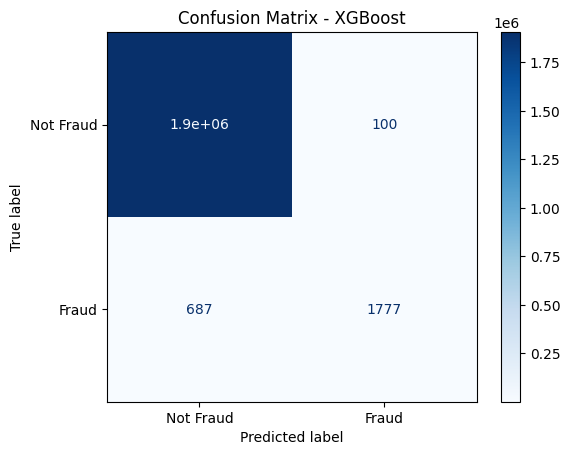

In [ ]:
# --- Final Prediction using Best Threshold ---
y_pred_xgb = (y_proba_xgb >= best_threshold_xgb).astype(int)

# --- Confusion Matrix ---
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb, display_labels=['Not Fraud', 'Fraud']).plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.grid(False)
plt.show()


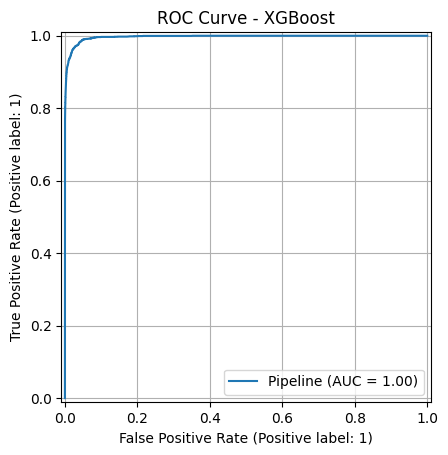

AUC Score (XGBoost): 0.9969


In [ ]:
# --- ROC Curve + AUC ---
RocCurveDisplay.from_estimator(xgb_pipeline, X_test, y_test)
plt.title("ROC Curve - XGBoost")
plt.grid(True)
plt.show()

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"AUC Score (XGBoost): {auc_xgb:.4f}")




In [ ]:
# --- Store Result ---
results['XGBoost'] = {
    'F1': max(f1_scores_xgb),
    'AUC': auc_xgb,
    'Best Threshold': best_threshold_xgb
}

In [ ]:
results

{'Decision Tree': {'F1': 0.29057920446615493,
  'AUC': np.float64(0.9199175680783653),
  'Best Threshold': np.float64(0.01)},
 'XGBoost': {'F1': 0.8187053674268602,
  'AUC': np.float64(0.9968843797606889),
  'Best Threshold': np.float64(0.99)}}

 # Support Vector Machine (SVM)

In [ ]:

print("\n\n===== Support Vector Machine (SVM) =====")

# --- Define Model ---
svm_model = SVC(
    kernel='rbf',            # or 'linear'
    C=1.0,
    probability=True,        # Important to enable probability outputs
    random_state=42
)

# --- Pipeline ---
svm_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),      # Include scaling!
    ('smote', SMOTE(random_state=42)),
    ('classifier', svm_model)
])

# --- Train Model ---
svm_pipeline.fit(X_train, y_train)

# --- Predict Probabilities for class 1 (fraud) ---
y_pred_svm = svm_pipeline.predict(X_test)
y_proba_svm = svm_pipeline.predict_proba(X_test)[:, 1]

# --- Threshold Tuning ---
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores_svm = []
precision_scores_svm = []
recall_scores_svm = []

for t in thresholds:
    y_pred_t = (y_proba_svm >= t).astype(int)
    f1_scores_svm.append(f1_score(y_test, y_pred_t))
    precision_scores_svm.append(precision_score(y_test, y_pred_t, zero_division=0))
    recall_scores_svm.append(recall_score(y_test, y_pred_t))

best_threshold_svm = thresholds[np.argmax(f1_scores_svm)]
print(f"Best Threshold for SVM: {best_threshold_svm:.2f}")





===== Support Vector Machine (SVM) =====


In [ ]:
# --- Final Predictions using best threshold ---
y_pred_svm = (y_proba_svm >= best_threshold_svm).astype(int)

# Classification report
print("===== Support Vector Machine (SVM) Classification Report =====")
print(classification_report(y_test, y_pred_svm))

# --- Confusion Matrix ---
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm_svm, display_labels=['Not Fraud', 'Fraud']).plot(cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.grid(False)
plt.show()



In [ ]:
# --- ROC Curve + AUC ---
RocCurveDisplay.from_estimator(svm_pipeline, X_test, y_test)
plt.title("ROC Curve - SVM")
plt.grid(True)
plt.show()

auc_svm = roc_auc_score(y_test, y_proba_svm)
print(f"AUC Score (SVM): {auc_svm:.4f}")



In [ ]:
# --- Store Results ---
results['SVM'] = {
    'F1': max(f1_scores_svm),
    'AUC': auc_svm,
    'Best Threshold': best_threshold_svm
}


# Naive Bayes

In [ ]:
# --- Naive Bayes ---
print("\n\n===== Naive Bayes =====")
# --- Pipeline ---
# --- Naive Bayes Pipeline ---
nb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GaussianNB())
])

# --- Train ---
nb_pipeline.fit(X_train, y_train)

# --- Predict ---
y_pred_nb = nb_pipeline.predict(X_test)
y_proba_nb = nb_pipeline.predict_proba(X_test)[:, 1]

##  Threshold Tuning for Naive Bayes (using F1-score)

In [ ]:
# --- Threshold Tuning ---
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores_nb = []
precision_scores_nb = []
recall_scores_nb = []

for t in thresholds:
    y_pred_thresh = (y_proba_nb >= t).astype(int)
    f1_scores_nb.append(f1_score(y_test, y_pred_thresh))
    precision_scores_nb.append(precision_score(y_test, y_pred_thresh))
    recall_scores_nb.append(recall_score(y_test, y_pred_thresh))

best_threshold_nb = thresholds[np.argmax(f1_scores_nb)]
print(f"Best Threshold for Naive Bayes: {best_threshold_nb:.2f}")

In [ ]:
#Plot threshold vs F1, precision, recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision, Recall, F1")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:


# Predict using best threshold
y_pred_best_nb = (y_proba_nb >= best_threshold_nb).astype(int)

# Classification report
print("===== Naive Bayes Classification Report =====")
print(classification_report(y_test,y_pred_best_nb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes (Best Threshold)")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba_nb)
plt.title("ROC Curve - Naive Bayes")
plt.grid(True)
plt.show()

# AUC Score
auc_nb = roc_auc_score(y_test, y_proba_nb)
print(f"AUC Score (Naive Bayes): {auc_nb:.4f}")


In [ ]:
# --- Store Results  ---
results = {}
results['Naive Bayes'] = {
    'F1': max(f1_scores),
    'AUC': auc_nb,
    'Best Threshold': best_threshold_nb
}


# Random Forest

In [ ]:
# --- Random Forest Pipeline  ---
rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor_tree),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [ ]:
# --- Train ---
rf_pipeline.fit(X_train, y_train)
# --- Predict Probabilities ---
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

## Tune threshold using F1 score

In [ ]:

# --- Threshold Tuning ---
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []
precision_scores = []
recall_scores = []

for t in thresholds:
    y_pred_t = (y_proba_rf >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))
    precision_scores.append(precision_score(y_test, y_pred_t))
    recall_scores.append(recall_score(y_test, y_pred_t))

best_threshold_rf = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold for Random Forest: {best_threshold_rf:.2f}")


In [ ]:
# --- Final Predictions using Best Threshold ---
y_pred_rf = (y_proba_rf >= best_threshold_rf).astype(int)

# --- Evaluation ---
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest (Best Threshold)")
plt.show()



In [ ]:
# --- ROC Curve ---
RocCurveDisplay.from_estimator(rf_pipeline, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.grid(True)
plt.show()

# --- AUC Score ---
auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"AUC Score (Random Forest): {auc_rf:.4f}")

# --- Store Results (Optional) ---
results = {}
results['Random Forest'] = {
    'F1': max(f1_scores),
    'AUC': auc_rf,
    'Best Threshold': best_threshold_rf
}


# Plot All ROC Curves Together

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# --- Compute ROC curves and AUCs ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# --- Calculate AUC Scores ---
auc_lr = auc(fpr_lr, tpr_lr)
auc_svm = auc(fpr_svm, tpr_svm)
auc_nb = auc(fpr_nb, tpr_nb)
auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# --- Plot All ROC Curves ---
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})")
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {auc_nb:.2f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Plot formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


 # Model Comparison Table
We'll collect all model results into a single DataFrame.

In [ ]:
 #Create a Dictionary to Store Results

results = {
    'Logistic Regression': {
        'F1': max(f1_scores_lr),
        'AUC': auc_lr,
        'Best Threshold': best_threshold_lr
    },
    'SVM': {
        'F1': max(f1_scores_svm),
        'AUC': auc_svm,
        'Best Threshold': best_threshold_svm
    },
    'Naive Bayes': {
        'F1': max(f1_scores_nb),
        'AUC': auc_nb,
        'Best Threshold': best_threshold_nb
    },
    'Decision Tree': {
        'F1': max(f1_scores_dt),
        'AUC': auc_dt,
        'Best Threshold': best_threshold_dt
    },
    'Random Forest': {
        'F1': max(f1_scores_rf),
        'AUC': auc_rf,
        'Best Threshold': best_threshold_rf
    },
    'XGBoost': {
        'F1': max(f1_scores_xgb),
        'AUC': auc_xgb,
        'Best Threshold': best_threshold_xgb
    }
}


# Save the Best Model

In [ ]:
import joblib

# Save best model (example: XGBoost)
joblib.dump(best_xgb, 'best_fraud_model.pkl')

# Load it later
# loaded_model = joblib.load('best_fraud_model.pkl')
